In [1]:
%load_ext autoreload
%autoreload 2

------------------------------

## Config

In [2]:
import sys

In [3]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [4]:
from Util import to_log2_tpm
from Util import long_header


<font color='red'> **Note:** for `H3K9me2` samples some of these Figures are well defined (need some manual adaptation): </font>
* <font color='red'> **Figure3-A** </font>
* <font color='red'> **Figure3-B** </font>

<font color='red'> **Attention!** for `H3K9me2` samples It's possible to use other directories than the default (e.g. `ChIP/h3k9me2`) </font>

In [5]:
h3k9me2_analysis=False
#h3k9me2_analysis=True

In [6]:
h3k9me2_dir = 'h3k9me2' # use longest 3 mRNA genes
h3k9me2_dir = 'strict_mean_h3k9me2'
h3k9me2_dir = 'strict_median_h3k9me2'
#h3k9me2_dir = 'strict_q98_h3k9me2'
#h3k9me2_dir = 'strict_q95_h3k9me2'
#h3k9me2_dir = 'wo_ip_subtraction_h3k9me2'

- Result **directories**

In [7]:
#ratios_dir = os.path.join(project_data_dir, 'results/Ratios')
ratios_dir = ratios_dir
if h3k9me2_analysis:
    ratios_dir = os.path.join(ratios_dir, h3k9me2_dir)
ratios_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios'

----------------------------

# Create Boxplots: **Pol II ChIP Occupancy** (PO) **fold changes**

We defined two types of **Pol II ChIP fold changes** (delta_chip):
- `delta_chip_wt`: **mutants / wt**
- `delta_chip_clr4`: **mutants / clr4D**

This Notebook is used to generate the following **Box Plots**:

*  **Figure1**: *Heterochromatic repeats have reduced RNA Pol II occupancy, Transcription Efficiency and RNA stability.*
    *  WT / clr4Δ - **Figure1-B_stranded**
*  **Figure2**: *Contribution of distinct pathways to heterochromatic silencing*
    *  clr4Δ / WT - **Figure2-A_stranded**
*  **Figure3**: *RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants*
    *  Mutant group 1 - **Figure3-A_stranded**
    *  Mutant group 2 - **Figure3-B_stranded**

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [9]:
from viz_strands import prepare_4cat_data, multi_4cat_box_plot, my_multi_4cat_box_plot ## 4-category

-------------

## **I.** Data: **delta_chip_wt.csv**

In [10]:
#ratios_dir

- Import pairwise **Pol II ChIP Occupancy** (PO) **fold changes** between `WT_ChIP` and the rest of **ChIP** `mutant` **samples**: `delta_chip_wt.csv`

In [11]:
#delta_chip_wt_file = os.path.join(in_dir, 'delta_chip_wt.csv')
delta_chip_wt_file = os.path.join(ratios_dir, 'delta_chip_wt.csv')
delta_chip_wt_file  

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/delta_chip_wt.csv'

In [12]:
df = pd.read_csv(delta_chip_wt_file, sep='\t')
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.679798,0.590989,0.475865,0.638694,0.912488,1.464923,1.539828,0.414834,2.453280,1.419508,0.164257,0.489729,0.379880
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,0.159300,NaN,0.491166,0.268388,0.188594,NaN,0.172001,0.124179,0.145626,0.544436,0.044448,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1.043755,0.672485,0.790302,1.941771,2.801353,1.715025,5.343015,1.009087,4.877356,3.339233,0.897301,1.886897,0.624492
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,0.917359,0.175507,0.648496,0.508269,0.932228,1.060979,0.889223,0.471689,1.795616,1.826881,0.369095,0.510567,0.707747
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,2.068992,0.528055,0.428182,1.075409,2.271316,0.185691,0.877164,0.962926,4.712861,2.952906,2.254038,3.187280,1.773893


In [13]:
df.shape

(5159, 19)

- Get **sample columns** for filtering `NA`s properly:

In [14]:
init_sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]

In [15]:
# Check if PO ratio is not well defined for any mutants. All NaNs
df = df.dropna(axis=1, how='all')

In [16]:
# get sample_cols after filtering
sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]
len(sample_cols)
#sample_cols

13

In [17]:
print('Ignoring samples: {} wt PO ratio is not well defined!'.format(set(init_sample_cols).difference(sample_cols)))

Ignoring samples: set() wt PO ratio is not well defined!


In [18]:
#df[df['gene_id'].isin(non_degraded)][[xx for xx in df.columns if ('80' in xx) | (xx == 'gene_id') | (xx == 'category')]]

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from **division by zero**: drop `NaN's` </font>

In [19]:
# (NOT USED)
#df = df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#df = df.fillna({kk:0 for kk in sample_cols})

# drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
# => why not fillna(0) like before, in `GXP_BoxPlots.ipynb`?
df = df.dropna(subset = sample_cols) 
#df = df.dropna(0)

In [20]:
#df[df[sample_cols].isnull().any(1)]

In [21]:
df.shape

(5064, 19)

In [22]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not df[sample_cols].isnull().values.any()

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

In [23]:
# log transformed `ratios` will be used to visualize boxplots
# => compute log(x), there should be no issues zeros due to ratio defined as (1 + x) / (1 + y)
#df = to_log2_tpm(df, gene_id_col='gene_id')  # default shift=1
df = to_log2_tpm(df, gene_id_col='gene_id', shift=0)  # parastou used this, default shift=1

# Keep only Heterochromatic genes and  protein coding genes
df = df[(df['category'] == 'repeat') | (df['category'] == 'gene')]
#df = df[(df['bio_type'] == 'mRNA') | (df['category'] == 'repeat')]

if h3k9me2_analysis:
    # Keep only Heterochromatic genes
    df = df[df['category'] != 'gene']
    
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,-0.556822,-0.758796,-1.071375,-0.646803,-0.132123,0.550825,0.622769,-1.269396,1.294712,0.505391,-2.605974,-1.029944,-1.396382
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,0.061784,-0.572426,-0.339525,0.957373,1.486124,0.778230,2.417654,0.013050,2.286099,1.739517,-0.156336,0.916016,-0.679245
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,-0.124442,-2.510401,-0.624830,-0.976335,-0.101245,0.085396,-0.169383,-1.084093,0.844479,0.869383,-1.437934,-0.969827,-0.498695
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1.048928,-0.921241,-1.223704,0.104886,1.183529,-2.429028,-0.189082,-0.054503,2.236603,1.562136,1.172512,1.672326,0.826919
5,FP565355_region_18009..20128,NaN,2120,region,repeat,region,-0.578080,-0.667078,-1.097546,-0.725658,-0.174377,0.508798,0.563881,-1.305971,1.269392,0.476440,-2.688695,-1.084754,-1.448851


In [24]:
df.shape

(4899, 19)

In [25]:
#df[df['gene_id'].isin(non_degraded)]

In [26]:
assert not df[sample_cols].isnull().values.any()

----

### clr4Δ / WT - **Figure2-A_stranded**

- **Figure 2**: Contribution of distinct pathways to heterochromatic silencing 

    - **(A)** Box plot showing RNA Pol II occupancy (Pol II ChIP-seq) in clr4Δ cells relative to wild type cells for indicated genes. Average of at least two independent samples is shown. 


In [27]:
fig_dir = os.path.join(plots_dir, 'Figure2')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure2/Figure2-A_stranded.png


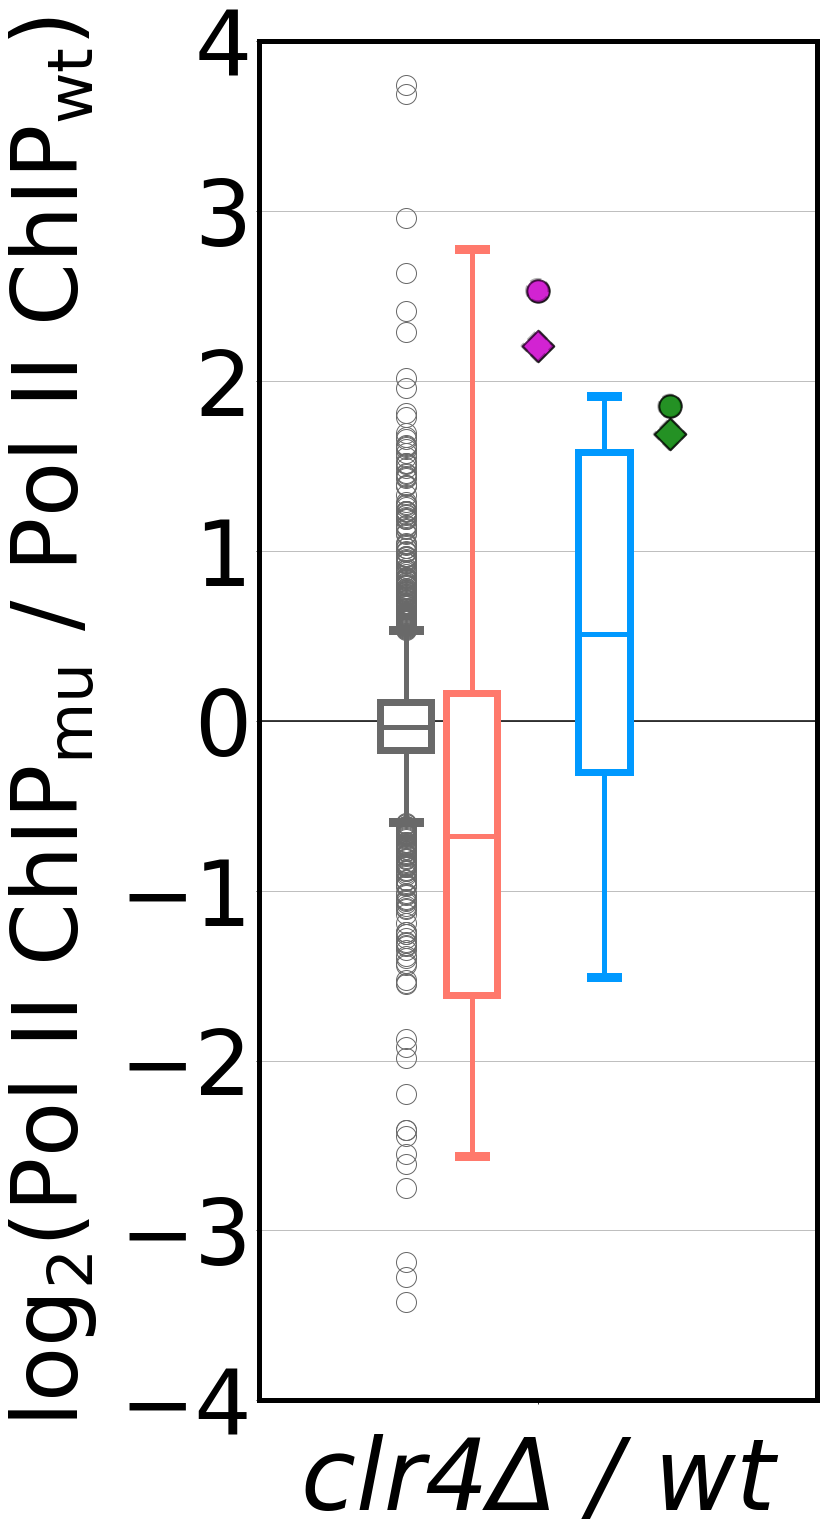

In [28]:
# data and labels
samples = ['80']
x_labels = ['clr4Δ / wt']

#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure2-A_stranded.png')
out_path = os.path.join(fig_dir, 'Figure2-A_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples, 
    x_labels, 
    out_path,
    figsize=(10, 25),
    dist=1, 
    y_label='$\mathrm{log_2(Pol\ II\ ChIP_{mu} \ / \ Pol\ II\ ChIP_{wt})}$', 
    y_lim=(-4, 4), 
    widths=.7,
    hlines=[(0,'black')], 
    xlable_size=100, ylable_size=90,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

--------------------

## Mutant group 1 - **Figure3-A_stranded**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(A+B)** Box plot showing RNA Pol II occupancy (S2P-RNA Pol II ChIP-seq) over indicated genes in mutant cells affecting.
    - **(A)** heterochromatin formation. Average of at least two independent samples is shown.

In [29]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if h3k9me2_analysis:
    fig_dir = os.path.join(fig_dir, h3k9me2_dir)
if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

In [30]:
#h3k9me2_analysis

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-A_stranded.png


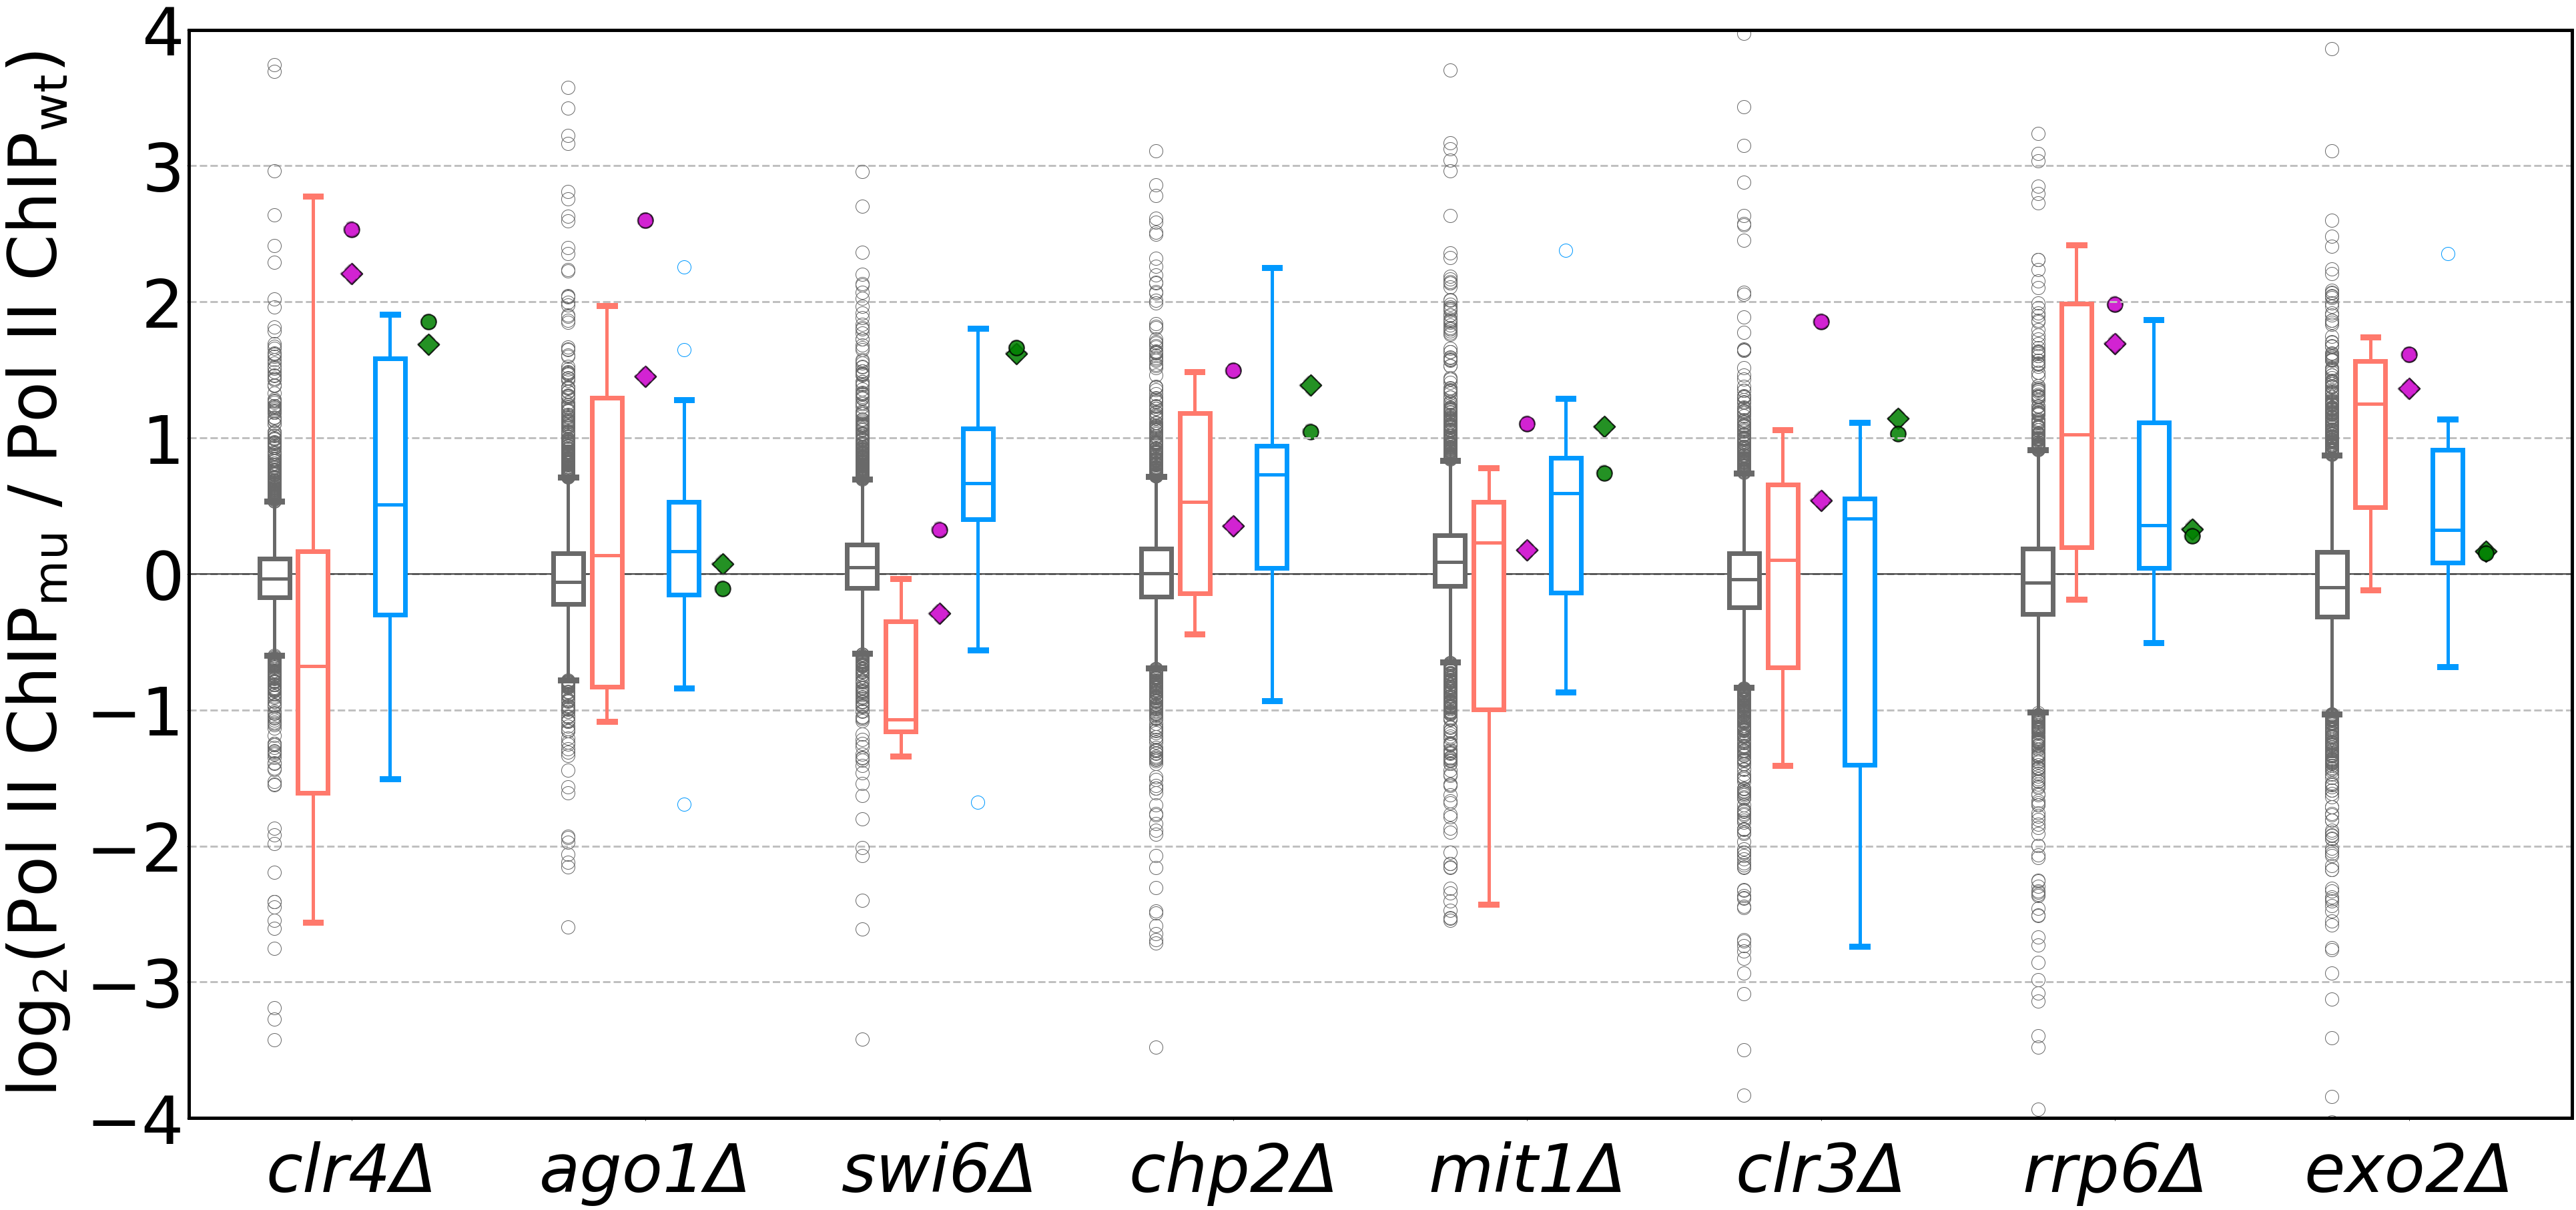

In [31]:
# data and labels
# samples = ['80', '638', '301', '324', '491', '302']
# x_labels = ['clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ']

# data and labels - new version
if not h3k9me2_analysis:
    
    samples = ['80', '638', '301', '324', '491', '302', '504', '530']
    x_labels = ['clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ', 'rrp6Δ', 'exo2Δ']
    
    y_label = '$\mathrm{log_2(Pol\ II\ ChIP_{mu} \ / \ Pol\ II\ ChIP_{wt})}$'
    
    y_lim = (-4, 4)
    
    # path and plot
    out_path = os.path.join(plots_dir, 'Figure3-A_stranded.png')
    out_path = os.path.join(fig_dir, 'Figure3-A_stranded.png')
    
else:
    samples = ['638', '301', '324', '491', '302', '504', '530'] # remove missing mutant 'clr4Δ' (80)
    x_labels = ['ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ', 'rrp6Δ', 'exo2Δ']
    
    #samples = ['301', '324', '491', '302', '504', '530'] # remove missing mutants 'ago1Δ' (638) and 'clr4Δ' (80)
    #x_labels = ['swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ', 'rrp6Δ', 'exo2Δ']
    
#     # remove protein coding genes
#     df = df[~(df['category'] == 'gene')] # use this!
#     #df = df[~(df['bio_type'] == 'mRNA')] ## missing some repeats?

    y_label = '$\mathrm{log_2(H3K9me2\ ChIP_{mu} \ / \ ChIP_{wt})}$'

    #y_lim=(-8, 6)
    y_lim=(-8, 8)
    #y_lim=(-15, 8)
    
    # path and plot
    out_path = os.path.join(plots_dir, 'Figure3-A_H3K9me2.png')
    out_path = os.path.join(fig_dir,  'Figure3-A_H3K9me2.png')

#data = prepare_4cat_data(df, samples)

print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples,                     
    x_labels,
    out_path,
    figsize=(len(samples) * 8, 30),
    #figsize=(60, 30),
    dist=6,
    y_label=y_label, 
    y_lim=y_lim,
    hlines=[(0, 'black')],
    #widths=.9,
    widths=.7, 
    xlable_size=100, ylable_size=100, 
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 2 - **Figure3-B_stranded**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(A+B)** Box plot showing RNA Pol II occupancy (S2P-RNA Pol II ChIP-seq) over indicated genes in mutant cells affecting.
    - **(B)** RNA degradation relative to wild type cells. Average of at least two independent samples is shown.

In [32]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if h3k9me2_analysis:
    fig_dir = os.path.join(fig_dir, h3k9me2_dir)
if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-B_stranded.png


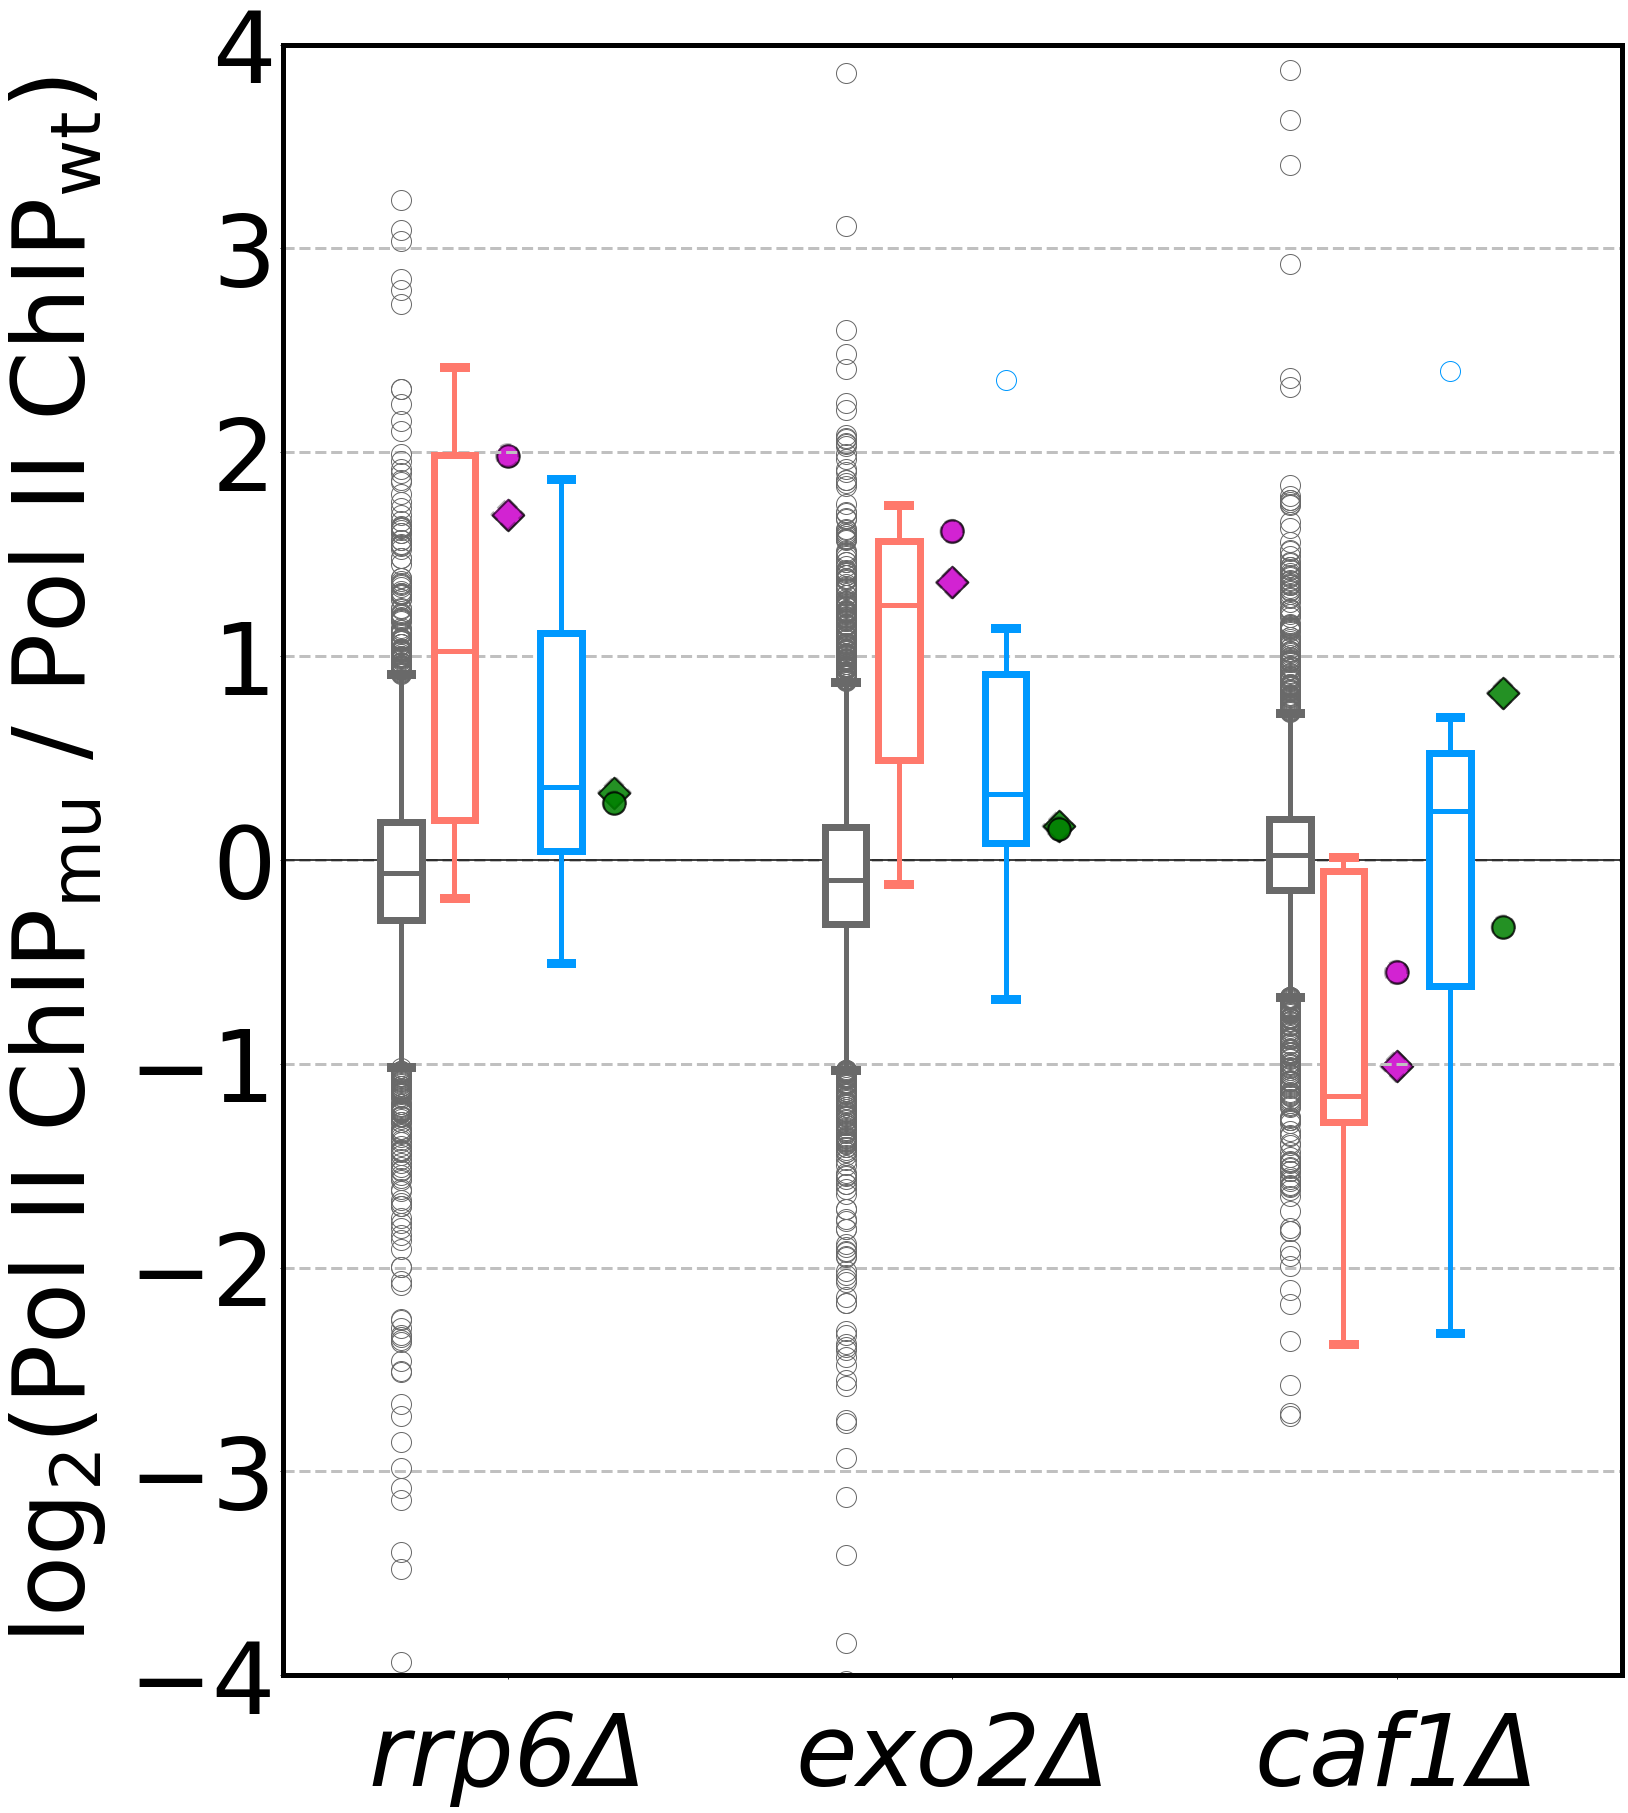

In [33]:
# data and labels
samples = ['504', '530', '510']
x_labels = ['rrp6Δ', 'exo2Δ', 'caf1Δ']

#data = prepare_4cat_data(df, samples)

if not h3k9me2_analysis:
    
    y_label = '$\mathrm{log_2(Pol\ II\ ChIP_{mu} \ / \ Pol\ II\ ChIP_{wt})}$'
    
    y_lim = (-4, 4)
        
    # path and plot
    out_path = os.path.join(plots_dir, 'Figure3-B_stranded.png')
    out_path = os.path.join(fig_dir, 'Figure3-B_stranded.png')
    
else:
    
    y_label = '$\mathrm{log_2(H3K9me2\ ChIP_{mu} \ / \ ChIP_{wt})}$'

    #y_lim=(-8, 6)
    y_lim=(-9, 8)
    #y_lim=(-15, 8)
    
#     # remove protein coding genes
#     df = df[~(df['category'] == 'gene')] # use this!
#     #df = df[~(df['bio_type'] == 'mRNA')] ## missing some repeats?
    
    # path and plot
    out_path = os.path.join(plots_dir, 'Figure3-B_H3K9me2.png')
    out_path = os.path.join(fig_dir, 'Figure3-B_H3K9me2.png')

print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples,                     
    x_labels,
    out_path,
    figsize=(len(samples) * 8, 30),
    #figsize=(24, 30),
    #figsize=(12, 25),
    dist=5,
    #dist=3,
    y_label=y_label, 
    y_lim=y_lim,
    #y_lim=(-3, 14), 
    hlines=[(0, 'black')],
    #widths=.9,
    widths=.7,
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 3 - **Figure3-B_stranded-extra-ccr4-not-1**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(A+B)** Box plot showing RNA Pol II occupancy (S2P-RNA Pol II ChIP-seq) over indicated genes in mutant cells affecting.
    - **(B)** RNA degradation relative to wild type cells. Average of at least two independent samples is shown.

In [34]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-B_stranded-extra-ccr4-not-1.png


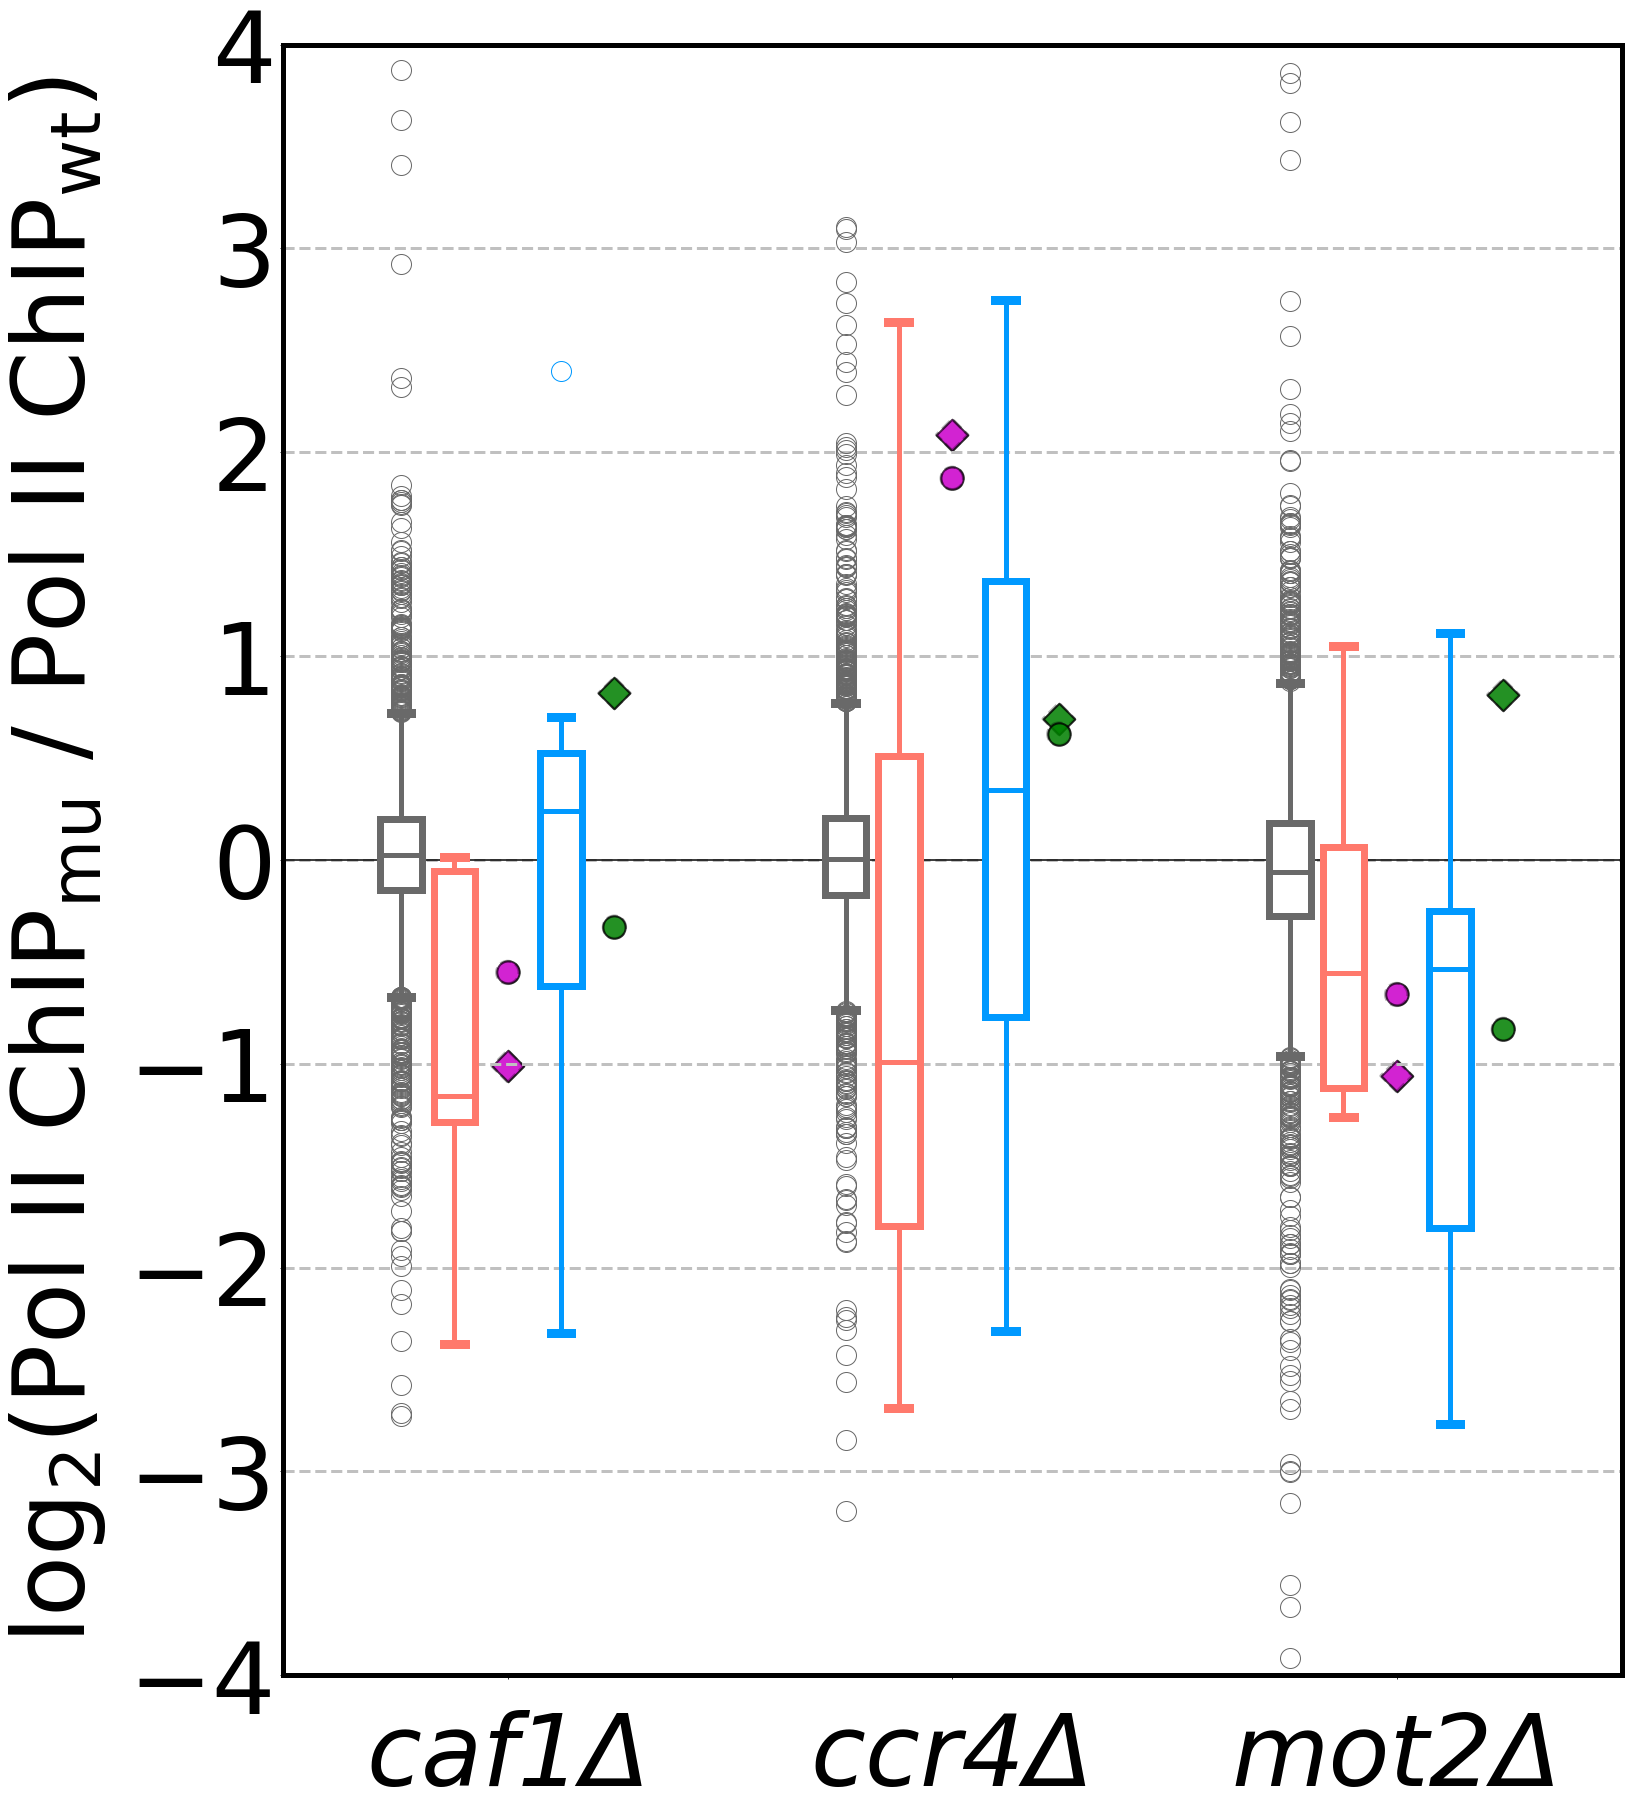

In [35]:
# data and labels
# samples = ['510', '544', '1022']
# x_labels = ['caf1Δ', 'ccr4Δ', 'mot2Δ']

# # data and labels - new version v1
# samples = ['504', '530', '510', '544', '1022']
# x_labels = ['rrp6Δ', 'exo2Δ', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

# data and labels - new version v2
samples = ['510', '544', '1022']
x_labels = ['caf1Δ', 'ccr4Δ', 'mot2Δ']

#data = prepare_4cat_data(df, samples)

# paths and plot
out_path = os.path.join(plots_dir, 'Figure3-B_stranded-extra-ccr4-not-1.png')
out_path = os.path.join(fig_dir, 'Figure3-B_stranded-extra-ccr4-not-1.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples,                     
                    x_labels,
                    out_path, 
                    figsize=(len(samples) * 8, 30),
                    #figsize=(40, 30),
                    #figsize=(12, 25),
                    dist=5,
                    #dist=3,
                    y_label='$\mathrm{log_2(Pol\ II\ ChIP_{mu} \ / \ Pol\ II\ ChIP_{wt})}$', 
                    y_lim=(-4, 4),
                    #y_lim=(-3, 14), 
                    hlines=[(0, 'black')],
                    #widths=.9,
                    widths=.7,
                    xlable_size=100, ylable_size=100,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

----

## Mutant group 4 - **Figure-B_stranded-extra-ccr4-not-2**

- **Figure 3**: RNA Pol II occupancy, transcription efficiency and RNA stability in different mutants
    - **(A+B)** Box plot showing RNA Pol II occupancy (S2P-RNA Pol II ChIP-seq) over indicated genes in mutant cells affecting.
    - **(B)** RNA degradation relative to wild type cells. Average of at least two independent samples is shown.

In [36]:
fig_dir = os.path.join(plots_dir, 'Figure3')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure3/Figure3-B_stranded-extra-ccr4-not-2.png


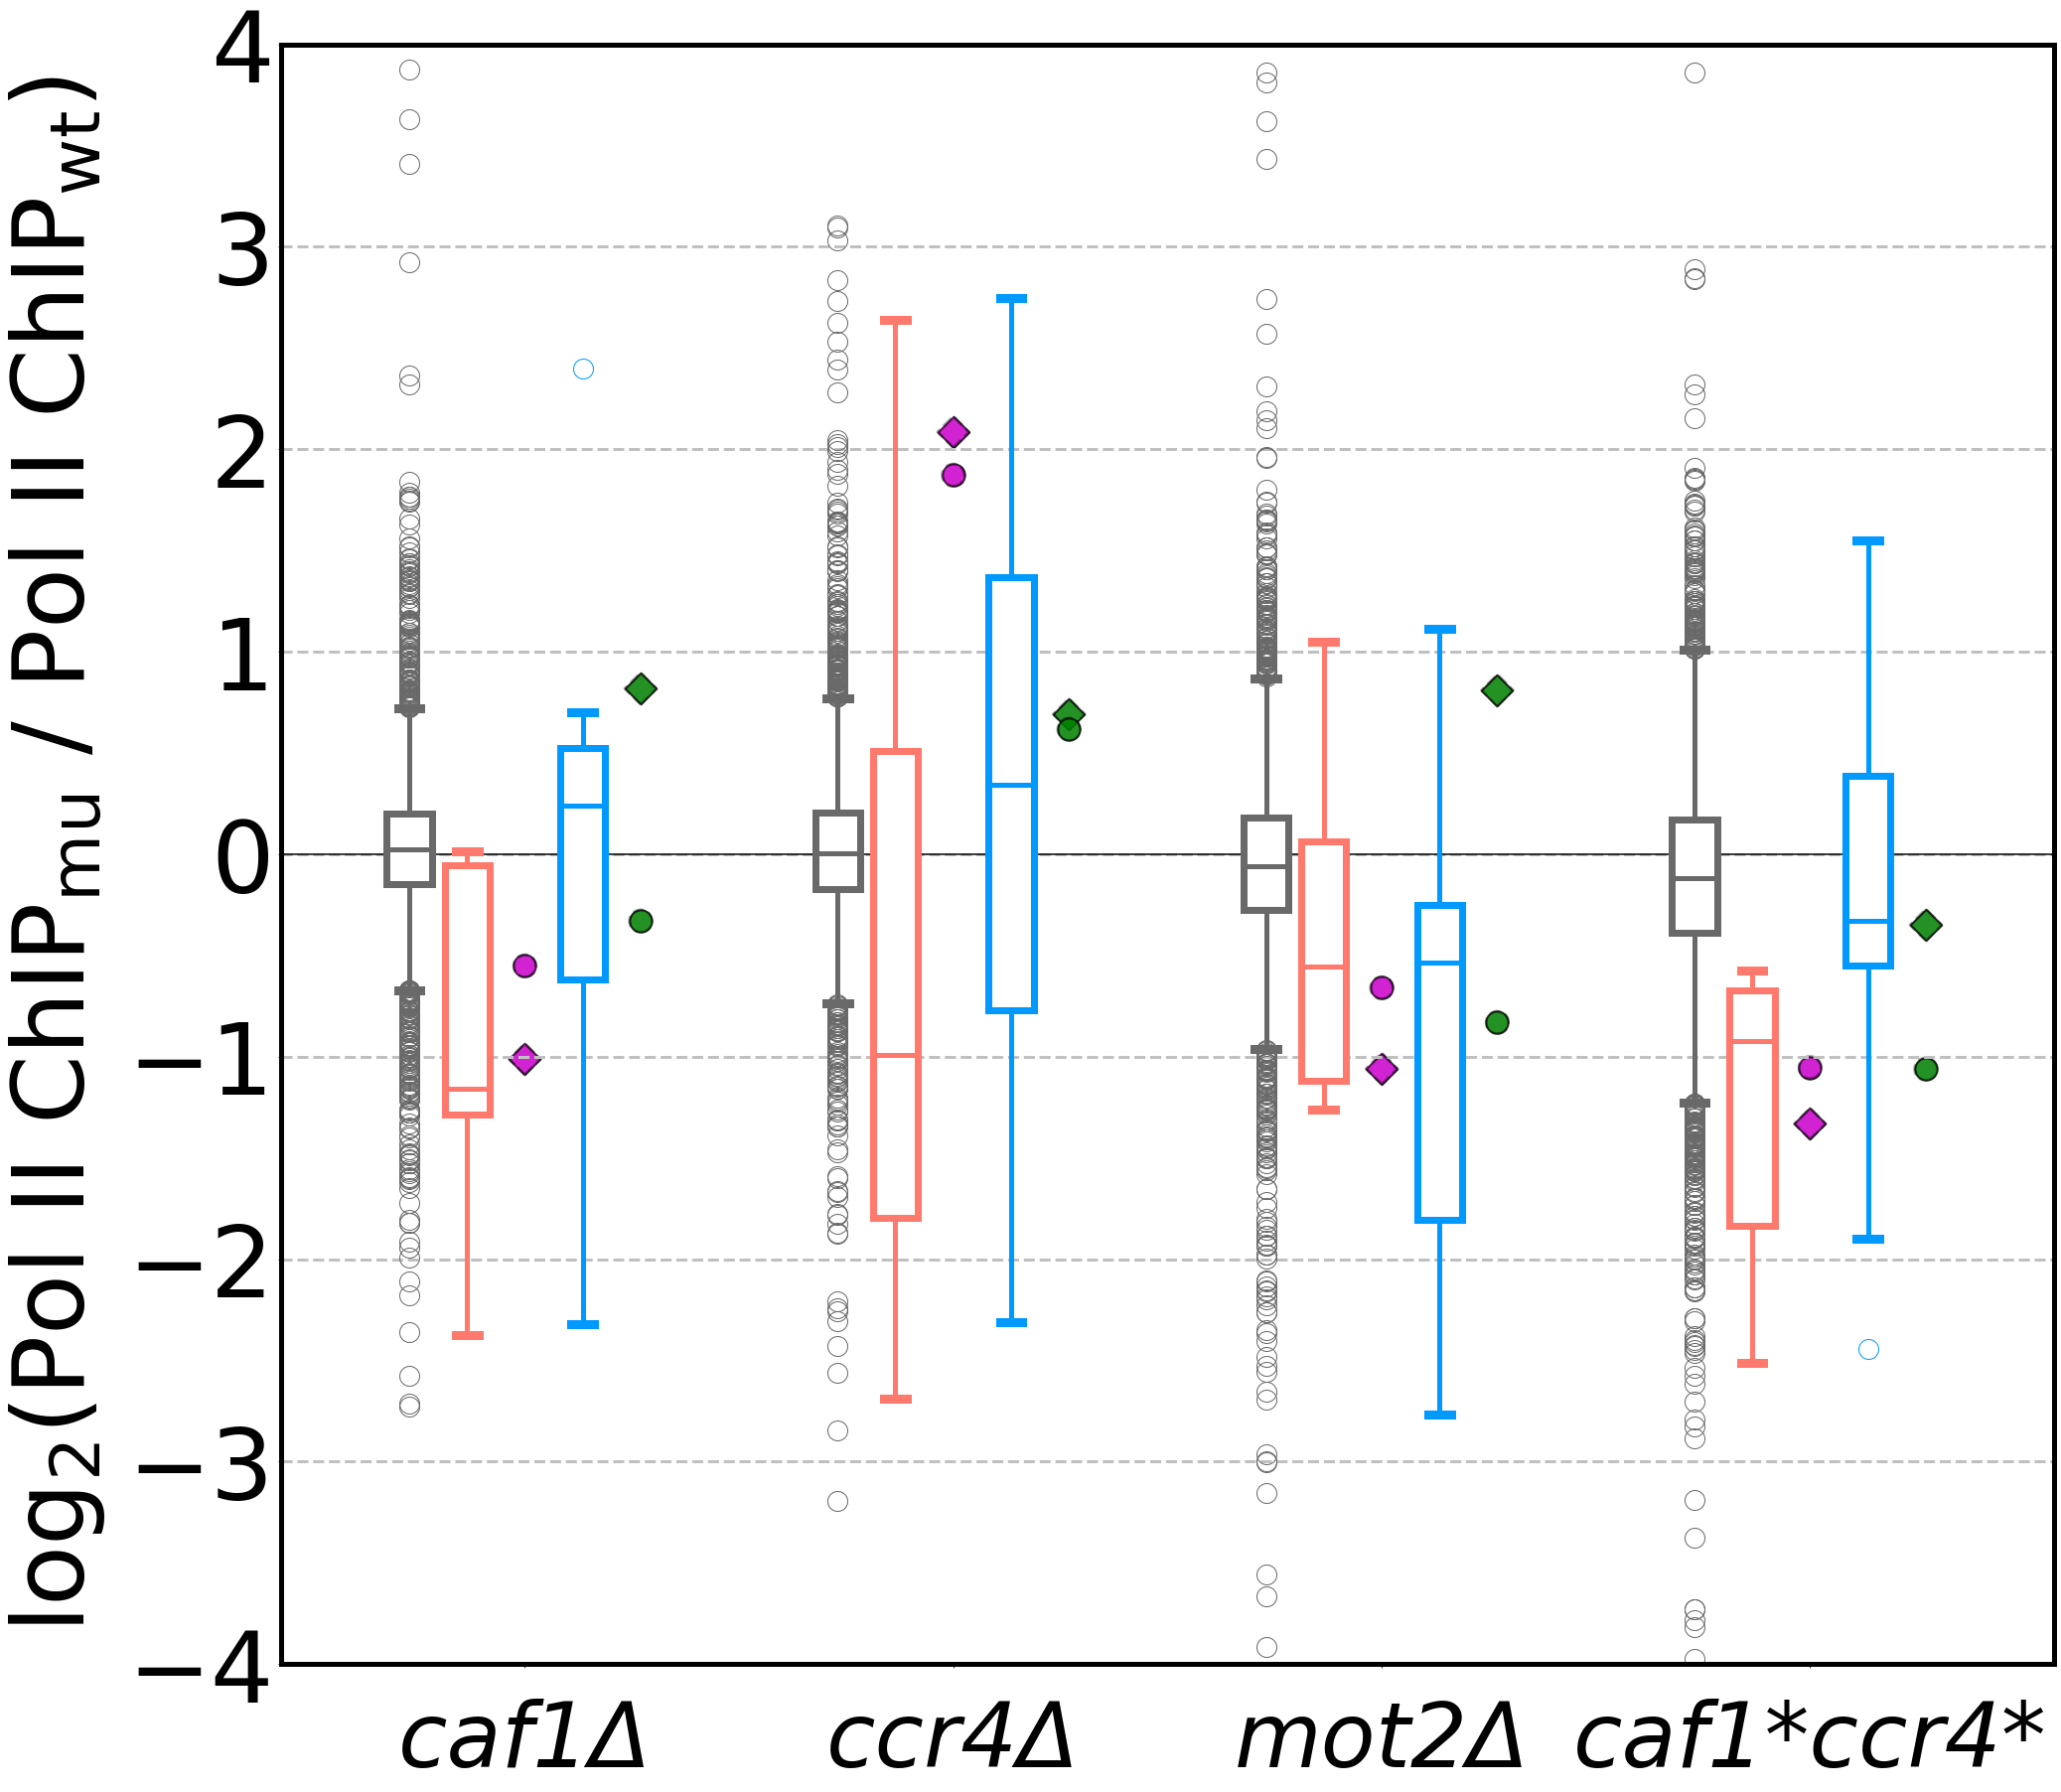

In [37]:
# data and labels
samples = ['510', '544', '1022', '1168']
x_labels = ['caf1Δ', 'ccr4Δ', 'mot2Δ', 'caf1*ccr4*']

#data = prepare_4cat_data(df, samples)

# paths and plot
out_path = os.path.join(plots_dir, 'Figure3-B_stranded-extra-ccr4-not-2.png')
out_path = os.path.join(fig_dir, 'Figure3-B_stranded-extra-ccr4-not-2.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples,                     
                    x_labels,
                    out_path, 
                    figsize=(len(samples) * 8, 30),
                    #figsize=(32, 30),
                    #figsize=(12, 25),
                    dist=5,
                    #dist=3,
                    y_label='$\mathrm{log_2(Pol\ II\ ChIP_{mu} \ / \ Pol\ II\ ChIP_{wt})}$', 
                    y_lim=(-4, 4),
                    #y_lim=(-3, 14), 
                    hlines=[(0, 'black')],
                    #widths=.9,
                    widths=.7,
                    xlable_size=90, ylable_size=100,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

-------------

# **II.** Data: **delta_chip_clr4.csv**

- Import pairwise **Pol II ChIP Occupancy** (PO) **fold changes** between  `80_ChIP` **(clr4D)** and the rest of **ChIP** `mutant` **samples**: `delta_chip_clr4.csv`

In [38]:
#delta_chip_clr4_file = os.path.join(in_dir, 'delta_chip_clr4.csv')
delta_chip_clr4_file = os.path.join(ratios_dir, 'delta_chip_clr4.csv')
delta_chip_clr4_file  

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/delta_chip_clr4.csv'

In [39]:
df = pd.read_csv(delta_chip_clr4_file, sep='\t')
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1.789505,1.555724,1.252671,1.681303,2.402039,3.856273,4.053453,1.092011,6.458032,3.736722,0.432391,1.289166,2.632407
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1.671367,1.076851,1.265511,3.109361,4.485812,2.746273,8.555779,1.615853,7.810119,5.347119,1.436849,3.021492,1.601302
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1.296168,0.247980,0.916283,0.718151,1.317178,1.499094,1.256414,0.666465,2.537088,2.581264,0.521508,0.721398,1.412935
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1.166357,0.297681,0.241380,0.606242,1.280413,0.104680,0.494485,0.542832,2.656790,1.664647,1.270673,1.796771,0.563732


In [40]:
df.shape

(5159, 19)

- Get **sample columns** for filtering `NA`s properly:

In [41]:
init_sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]

In [42]:
# Check if PO ratio is not well defined for any mutants. All NaNs
df = df.dropna(axis=1, how='all')

In [43]:
# get sample_cols after filtering
sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]
len(sample_cols)
#sample_cols

13

In [44]:
print('Ignoring samples: {} clr4 PO ratio is not well defined!'.format(set(init_sample_cols).difference(sample_cols)))

Ignoring samples: set() clr4 PO ratio is not well defined!


In [45]:
#df[df['gene_id'].isin(non_degraded)][[xx for xx in df.columns if ('80' in xx) | (xx == 'gene_id') | (xx == 'category')]]

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from **division by zero**: drop `NaN's` </font>

In [46]:
# (NOT USED)
#df = df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#df = df.fillna({kk:0 for kk in sample_cols})

# drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
# => why not fillna(0) like before, in `GXP_BoxPlots.ipynb`?
df = df.dropna(subset = sample_cols) 
#df = df.dropna(0)

In [47]:
#df[df[sample_cols].isnull().any(1)]

In [48]:
df.shape

(5064, 19)

In [49]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not df[sample_cols].isnull().values.any()

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

In [50]:
#df = to_log2_tpm(df, shift=0)
df = to_log2_tpm(df, gene_id_col='gene_id', shift=0)

# Keep only Heterochromatic genes and  protein coding genes 
#df = df[(df['category'] == 'repeat') | (df['type'] == 'gene')]
df = df[(df['bio_type'] == 'mRNA') | (df['category'] == 'repeat')]
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.839561,0.637586,0.325008,0.749580,1.264260,1.947207,2.019151,0.126987,2.691095,1.901773,-1.209591,0.366438,1.396382
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,0.741029,0.106819,0.339720,1.636618,2.165369,1.457475,3.096899,0.692296,2.965345,2.418762,0.522909,1.595261,0.679245
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,0.374253,-2.011706,-0.126135,-0.477640,0.397450,0.584091,0.329312,-0.585399,1.343173,1.368077,-0.939239,-0.471133,0.498695
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,0.222009,-1.748160,-2.050623,-0.722033,0.356610,-3.255947,-1.016001,-0.881422,1.409684,0.735217,0.345593,0.845407,-0.826919
5,FP565355_region_18009..20128,NaN,2120,region,repeat,region,0.870771,0.781773,0.351305,0.723193,1.274474,1.957648,2.012732,0.142880,2.718243,1.925290,-1.239844,0.364096,1.448851


In [51]:
df.shape

(5064, 19)

In [52]:
#df[df['gene_id'].str.contains('SPNCRNA')]

In [53]:
#df[df['gene_id'].isin(non_degraded)]

In [54]:
assert not df[sample_cols].isnull().values.any()

----------------------------

## WT / clr4Δ - **Figure1-B_stranded**

- **Figure 1**. Heterochromatic repeats have reduced RNA Pol II occupancy, Transcription Efficiency and RNA stability.
 - **(B)** Box plot showing RNA Pol II occupancy (S2P- RNA Pol II ChIP-seq) in wild type cells relative to clr4Δ cells for protein coding genes, centromeric dg/dh, subtelomeric tlh/SPAC212.10 and the remaining heterochromatic genes (subtelomeric and mat region). Average of at least two independent samples is shown.

In [55]:
fig_dir = os.path.join(plots_dir, 'Figure1')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure1/Figure1-B_stranded.png


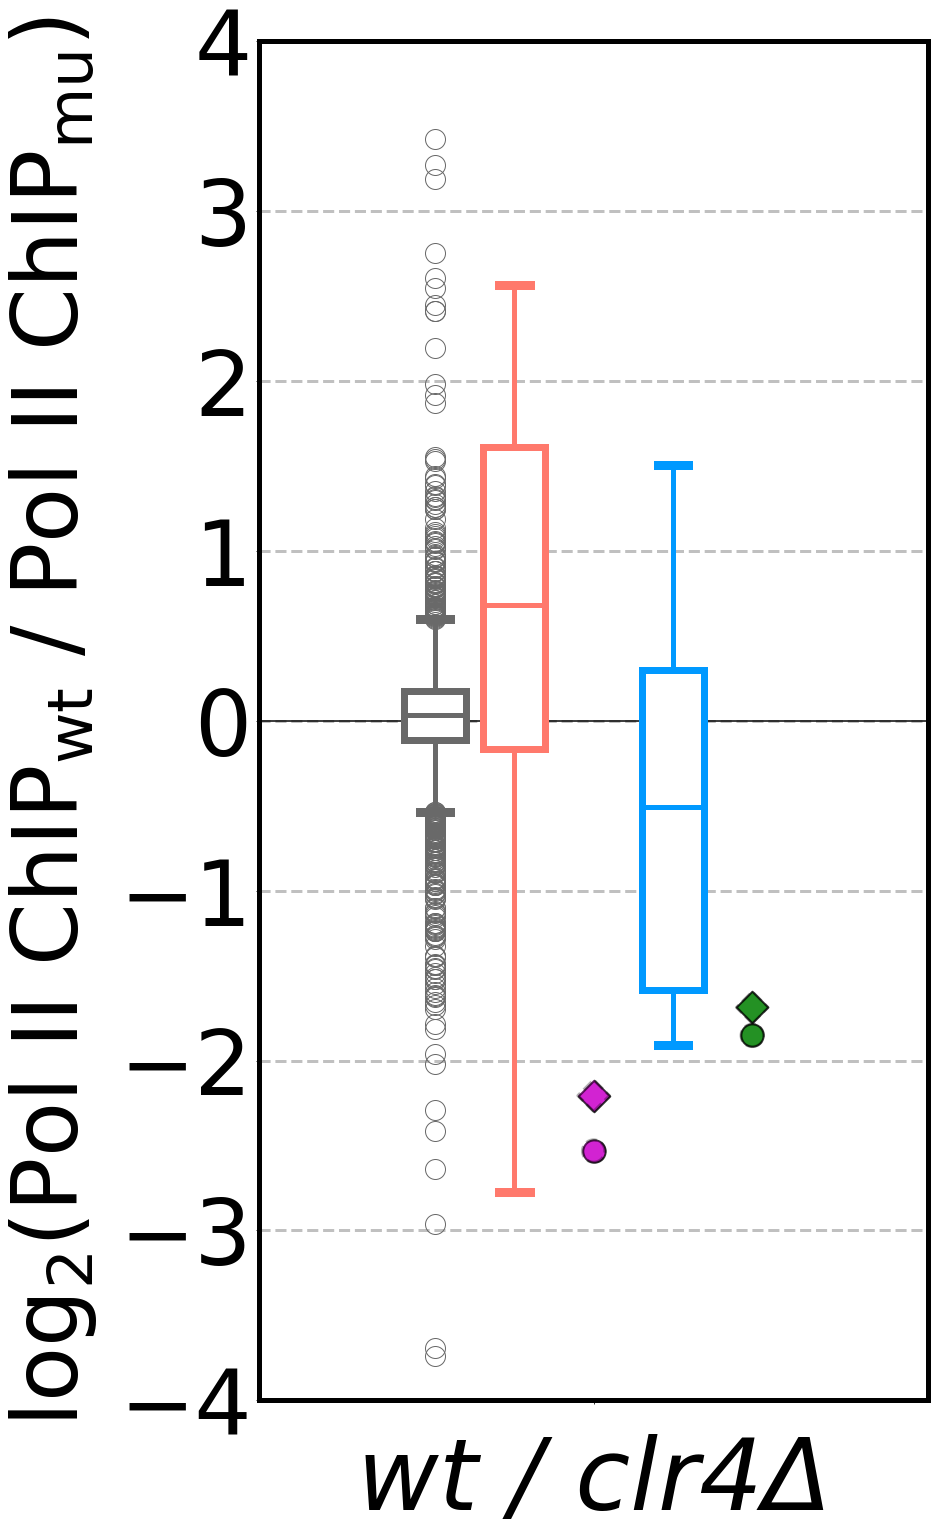

In [56]:
# data and labels
samples = ['WT']
x_labels = ['wt / clr4Δ']

data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure1-B_stranded.png')
out_path = os.path.join(fig_dir, 'Figure1-B_stranded.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(df, samples, 
                    x_labels,
                    out_path, 
                    figsize=(12, 25),
                    dist=1, 
                    y_label='$\mathrm{log_2(Pol\ II\ ChIP_{wt} \ / \ Pol\ II\ ChIP_{mu})}$', 
                    y_lim=(-4, 4), 
                    widths=.7,
                    hlines=[(0,'black')],
                    xlable_size=100, ylable_size=90,
                    annotate=annotate_plots,
                    include_mat_locus_vis = include_mat_locus_vis)

--------------------